In [1]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
market = Market()

In [3]:
market.connect()
sp500 = market.retrieve("sp500").rename(columns={"Symbol":"ticker"})
market.disconnect()

In [4]:
start_date = datetime(2001,1,1)
end_date = datetime(2020,1,1)
lookbacks = [1,5,20,60]
positions = 20

In [5]:
parameters = Parameters.parameters_lite(lookbacks)

In [6]:
len(parameters)

16

In [7]:
simulation = []
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        ticker_data = market.retrieve_ticker_prices("stocks",ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data = ticker_data[["date","ticker","adjclose"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
        ticker_data[f"return"] = (ticker_data["adjclose"].shift(-1) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 489/489 [00:36<00:00, 13.40it/s]


In [8]:
final

,date,ticker,adjclose,prev_close,window_1,rolling_1,window_5,rolling_5,window_20,rolling_20,window_60,rolling_60,return
61,2000-03-30,MMM,24.209033,23.836377,24.176392,23.836377,23.392998,24.101317,23.428360,23.278617,25.512158,24.437092,-0.004944
62,2000-03-31,MMM,24.089348,24.209033,23.836377,24.209033,23.665010,24.210121,23.409319,23.318603,24.498484,24.432268,0.037489
63,2000-04-03,MMM,24.992427,24.089348,24.209033,24.089348,24.720415,24.083908,24.345039,23.305819,25.747331,24.404635,0.011537
64,2000-04-04,MMM,25.280759,24.992427,24.089348,24.992427,24.108389,24.260715,23.733013,23.368789,27.247569,24.367049,-0.019475
65,2000-04-05,MMM,24.788418,25.280759,24.992427,25.280759,24.176392,24.481589,22.508961,23.507379,27.788195,24.325258,0.024690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2641,2023-08-01,ZTS,185.510000,188.090000,189.900000,188.090000,185.580000,189.766000,172.210000,176.604218,177.730000,173.947906,-0.018921
2642,2023-08-02,ZTS,182.000000,185.510000,188.090000,185.510000,190.150000,188.838000,170.230000,177.368218,178.470000,174.065239,-0.006154
2643,2023-08-03,ZTS,180.880000,182.000000,185.510000,182.000000,192.000000,186.838000,169.350000,178.000718,186.230000,173.994739,-0.012439
2644,2023-08-04,ZTS,178.630000,180.880000,182.000000,180.880000,188.690000,185.276000,168.470000,178.621218,184.870000,173.928239,0.011532


In [9]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.91s/it]


In [10]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [11]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.23it/s]


In [12]:
performance = pd.DataFrame(report)

In [13]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback
4778,493.556353,9,window,True,5
4778,484.963645,3,rolling,True,60
4778,377.330613,2,rolling,True,20
4778,338.671114,1,rolling,True,5
4778,329.675023,11,window,True,60
4778,300.265656,10,window,True,20
4778,129.047994,8,window,True,1
4778,21.131850,12,window,False,1
4778,20.723312,15,window,False,60
4778,16.024068,0,rolling,True,1


In [14]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [15]:
cumulative

position,date,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,pv
0,2001-01-02,1.213040,1.028293,1.094667,1.065565,1.240168,1.030013,0.986417,1.032140,1.007954,...,1.033731,1.170114,1.017232,0.972129,1.216169,1.102061,0.957818,0.905574,1.268293,1.082071
1,2001-01-03,1.000000,0.921757,0.877893,0.956091,0.898882,1.115001,0.956234,0.996573,0.861031,...,1.017500,1.155350,0.918798,1.013798,1.023172,0.953728,1.037187,0.927684,1.134615,1.063331
2,2001-01-04,0.981954,0.879457,0.975712,1.007857,0.953069,1.033056,1.031520,0.989557,0.792542,...,0.945489,1.030832,0.958140,0.959618,0.909152,1.018896,0.938835,0.845011,0.959070,1.019083
3,2001-01-05,0.986600,1.036255,0.962264,0.958333,1.006646,1.039865,1.039497,1.016143,0.962144,...,0.962330,1.016729,0.743300,1.026212,1.007035,1.031998,1.032576,1.022605,1.163919,1.017637
4,2001-01-08,1.103596,1.100413,1.089781,1.023299,0.988485,1.014719,1.033958,0.981673,0.950761,...,1.021277,0.992908,0.916160,1.036667,1.047689,0.994115,0.971831,0.927500,0.956140,1.021269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,2019-12-24,0.995042,1.002613,0.998348,1.000069,0.995658,1.002822,0.971071,1.002799,0.996201,...,0.996092,0.996429,0.986441,0.997660,1.002758,1.003779,0.991348,1.011341,1.001913,493.462152
4775,2019-12-26,1.000343,1.001460,1.003380,0.993017,0.998859,0.996584,1.000647,1.003941,0.999632,...,1.004678,0.993124,0.984742,0.987061,0.989825,1.009965,0.991736,1.000262,0.992924,492.257456
4776,2019-12-27,0.983918,0.991540,0.993387,0.991197,0.999616,0.990301,0.998808,1.008792,0.995313,...,1.005609,0.998629,0.996153,0.997897,0.991773,0.988303,1.001539,1.008795,0.989027,490.197590
4777,2019-12-30,0.997060,1.003431,1.001570,1.010459,1.006471,1.002626,1.004391,0.998223,1.009423,...,0.999539,1.013255,1.011702,1.027611,0.991709,1.002585,1.002789,1.004214,1.002745,492.825344


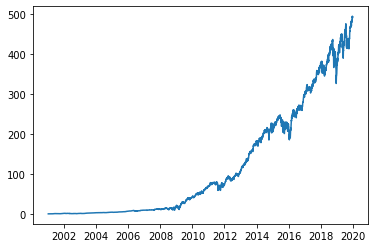

In [16]:
plt.plot(cumulative["date"],cumulative["pv"])

In [17]:
parameter

{'strategy': 'window', 'value': True, 'lookback': 5}